In [1]:
pip install pyspark

In [2]:
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
 
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover

In [3]:
# inicjalizacja SparkSession
myconf = pyspark.SparkConf().setAll([('spark.executor.cores', '4'), ('spark.cores.max', '4')])
spark = SparkSession.builder.config(conf=myconf).master("local[4]").appName("TWITTER_SENTIMENT").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
#sc = spark.sparkContext

In [4]:
TwitterTrainData = StructType([
    StructField("Polarity", IntegerType(), nullable = False),
    StructField("TweetID", StringType(), False),
    StructField("CreatedAt", DateType(), True),
    StructField("Query", StringType(), True),
    StructField("UserName", StringType(), False),
    StructField("TweetText", StringType(), False)
])

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [6]:
tweets = spark.read.csv("/content/drive/MyDrive/training.1600000.processed.noemoticon.csv", 
                        schema=TwitterTrainData, header=False, sep = ',')
tweets.show(truncate=False, n=5)

+--------+----------+---------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|Polarity|TweetID   |CreatedAt|Query   |UserName       |TweetText                                                                                                          |
+--------+----------+---------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0       |1467810369|null     |NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0       |1467810672|null     |NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0       |1467810917|null     |NO_QUERY|mattycus       |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out

In [7]:
tweets.groupBy("Polarity").count().show(5)

+--------+------+
|Polarity| count|
+--------+------+
|       4|800000|
|       0|800000|
+--------+------+



In [8]:
#Zamiana flagi pozytywnej z 4 na 1
tweets = tweets.withColumn("Polarity", when(col("Polarity")==4, 1).otherwise(col("Polarity")))

In [9]:
#Wyciągnięcie tylko istotnych pod kątem analizy sentymentu danych
tweetsCleansed = tweets.select("TweetText", col("Polarity").cast("Int").alias("label"))
 
#Uporządkowania danych w tweecie - zostawienie tylko znaków alfanumerycznych
#usunięcie whitespaców na początku/końcu
#usunięcie podwójnych spacji w środku zdań
#dodatkowo usuwa URLe i oznaczenia/odwołania typu @user
#na koniec wszystko do lowercase
tweetsCleansed = tweetsCleansed.withColumn("TweetText",
                                           lower(trim(regexp_replace(
                                               regexp_replace(
                                                   regexp_replace(col("TweetText"),"(http\S+)?(@\S+)?",""),
                                               "[^A-Za-z0-9:;/_(\s)#]", ""),
                                           "(\s)+", " "))))
tweetsCleansed.show(truncate = False,n=10)

+--------------------------------------------------------------------------------------------------------+-----+
|TweetText                                                                                               |label|
+--------------------------------------------------------------------------------------------------------+-----+
|awww thats a bummer you shoulda got david carr of third day to do it ;d                                 |0    |
|is upset that he cant update his facebook by texting it and might cry as a result school today also blah|0    |
|i dived many times for the ball managed to save 50 the rest go out of bounds                            |0    |
|my whole body feels itchy and like its on fire                                                          |0    |
|no its not behaving at all im mad why am i here because i cant see you all over there                   |0    |
|not the whole crew                                                                             

In [10]:
#Podział danych na zbiór uczący i testujący. Tylko 10% dla informacyjnej ewaluacji celności predykcji
#To jest workaround, bo randomSplit na DataFrame gubi kolumny i dla TweetText zwraca same nulle...
#Więcej tutaj: https://community.cloudera.com/t5/Support-Questions/Pyspark-Table-Dataframe-returning-empty-records-from/m-p/35880#M23329
rdd_df = tweetsCleansed.rdd
trainingData, testingData = rdd_df.randomSplit([0.9, 0.1])
trainingData = spark.createDataFrame(trainingData)
testingData = spark.createDataFrame(testingData)

In [11]:
#Podzielnie TweetText na arraye z pojedynczymi słowami
#To samo możnaby zrobić ręcznie splitem i dodaniem kolumny
tokenizer = Tokenizer(inputCol="TweetText", outputCol="TweetWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(10)
 
#tokenizedTrain = trainingData.withColumn("TweetWords", split(col("TweetText"), " ")).show(10)
#tokenizedTrain = trainingData.select(split(trainingData.TweetText, " ").alias("word")).show(10)

+--------------------+-----+--------------------+
|           TweetText|label|          TweetWords|
+--------------------+-----+--------------------+
|awww thats a bumm...|    0|[awww, thats, a, ...|
|is upset that he ...|    0|[is, upset, that,...|
|my whole body fee...|    0|[my, whole, body,...|
|no its not behavi...|    0|[no, its, not, be...|
|  not the whole crew|    0|[not, the, whole,...|
|          need a hug|    0|      [need, a, hug]|
|nope they didnt h...|    0|[nope, they, didn...|
|spring break in p...|    0|[spring, break, i...|
|i just repierced ...|    0|[i, just, repierc...|
|i couldnt bear to...|    0|[i, couldnt, bear...|
+--------------------+-----+--------------------+
only showing top 10 rows



In [12]:
#Usunięcie zbędnych słów (zaimiki, przyimiki) przy pomocy wbudowanej biblioteki
swr = StopWordsRemover(inputCol="TweetWords", outputCol="TweetWordsFiltered")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(5)

+--------------------+-----+--------------------+--------------------+
|           TweetText|label|          TweetWords|  TweetWordsFiltered|
+--------------------+-----+--------------------+--------------------+
|awww thats a bumm...|    0|[awww, thats, a, ...|[awww, thats, bum...|
|is upset that he ...|    0|[is, upset, that,...|[upset, cant, upd...|
|my whole body fee...|    0|[my, whole, body,...|[whole, body, fee...|
|no its not behavi...|    0|[no, its, not, be...|[behaving, im, ma...|
|  not the whole crew|    0|[not, the, whole,...|       [whole, crew]|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [13]:
#Przekształcenie słów w hashe przy pomocy wbudowanej biblioteki
hashTF = HashingTF(inputCol="TweetWordsFiltered", outputCol="features")
numericTrainData = hashTF.transform(SwRemovedTrain)#.select('label', 'MeaningfulWords', 'features')
 
numericTrainData.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+
|           TweetText|label|          TweetWords|  TweetWordsFiltered|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|awww thats a bumm...|    0|[awww, thats, a, ...|[awww, thats, bum...|(262144,[10345,52...|
|is upset that he ...|    0|[is, upset, that,...|[upset, cant, upd...|(262144,[59577,61...|
|my whole body fee...|    0|[my, whole, body,...|[whole, body, fee...|(262144,[34121,80...|
|no its not behavi...|    0|[no, its, not, be...|[behaving, im, ma...|(262144,[1968,853...|
|  not the whole crew|    0|[not, the, whole,...|       [whole, crew]|(262144,[56326,80...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [14]:
#Trenowanie modelu na danych testowych, ponownie wykorzystana wbudowana biblioteka
#https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression
lr = LogisticRegression(labelCol="label", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrainData)

In [15]:
#Przygotowanie danych testowych tj. nakładanie identycznych transformat co na dane treningowe czyli
#tokenizacji - zamiany stirngów na arraye
#usuwanie zbędnych słów
#hashowania wyrazów
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest)

In [16]:
#Predykcja na danych testowych, porównanie wartości i określenie celności na danych testowych
prediction = model.transform(numericTest)
 
predictionFinal = prediction.select(
    "TweetText", "label", "prediction")
predictionFinal.show(10)

+--------------------+-----+----------+
|           TweetText|label|prediction|
+--------------------+-----+----------+
|i dived many time...|    0|       0.0|
|hey long time no ...|    0|       1.0|
|        que me muera|    0|       0.0|
|i wish i got to w...|    0|       0.0|
|oh dear were you ...|    0|       0.0|
|blagh class at 8 ...|    0|       0.0|
|yay im happy for ...|    0|       1.0|
|not sure what the...|    0|       0.0|
|ugh92 degrees tom...|    0|       0.0|
|i had such a nice...|    0|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



In [17]:
correctPrediction = predictionFinal.filter(
    predictionFinal['prediction'] == predictionFinal['label']).count()
print(correctPrediction / predictionFinal.count())

0.7592094841940493


In [18]:
TwitterData = StructType([
    StructField("CreatedAt", TimestampType(), nullable = False),
    StructField("TweetID", StringType(), False),
    StructField("TweetText", StringType(), False),
    StructField("ScreenName", StringType(), True),
    StructField("Name", StringType(), True),
    StructField("Followers", IntegerType(), True),
    StructField("AccountCreationDate", DateType(), True),
    StructField("Urls", StringType(), True),
])

In [19]:
streamDF = spark.readStream.option("header", "true").option("maxFilesPerTrigger", 5).schema(TwitterData).csv(path="/content/drive/MyDrive/scraper").dropDuplicates(["TweetID"])

In [20]:
streamTweets = streamDF.withColumn("TweetText",
                                     lower(trim(regexp_replace(
                                       regexp_replace(
                                         regexp_replace(col("TweetText"),"(http\S+)?(@\S+)?",""),
                                         "[^A-Za-z0-9:;/_(\s)#]", ""),
                                       "(\s)+", " ")))).select("CreatedAt", "TweetText", "Followers").dropna(subset = "TweetText")
 
streamTweets = tokenizer.transform(streamTweets)
streamTweets = swr.transform(streamTweets)
streamTweets = hashTF.transform(streamTweets)
 
predictionStreamTweets = model.transform(streamTweets).select("CreatedAt", "TweetText", "Followers", "prediction")

In [21]:
predictionStreamTweets.writeStream.format("memory").queryName("MyPredictionTab").start()

In [ ]:
#type(predictionStreamTweets.writeStream.format("memory").queryName("MyPredictionTab3").start())
#MyPredictionTab.select("*")
type(spark.sql("select * from MyPredictionTab") )
#.show()

pyspark.sql.dataframe.DataFrame

In [22]:
spark.sql("select * from MyPredictionTab").show()

+---------+---------+---------+----------+
|CreatedAt|TweetText|Followers|prediction|
+---------+---------+---------+----------+
+---------+---------+---------+----------+



In [23]:
predictionStreamTweets.writeStream\
.format("csv")\
.outputMode("append")\
.option("checkpointLocation", "/content/drive/MyDrive/checkpoints")\
.option("path", "/content/drive/MyDrive/output")\
.trigger(processingTime='10 seconds')\
.start()

In [ ]:
# ORYGINAŁ 
predictionStreamTweets.writeStream\
.format("csv")\
.outputMode("append")\
.option("checkpointLocation", "/FileStore/tables/checkpoints")\
.option("path", "/FileStore/tables/output")\
.trigger(processingTime='10 seconds')\
.start()

In [ ]:
WinStreamDF3 = predictionStreamTweets\
.withWatermark("CreatedAt", "10 seconds") \
.withColumn("prediction",(when(col("prediction") == 0.0, -1).otherwise(col("prediction"))))\
.groupBy(window("CreatedAt", "10 seconds"),"prediction").agg(sum("Followers"),sum("prediction"))\
.withColumnRenamed("sum(Followers)","Followers").withColumnRenamed("sum(prediction)","Score")#.sort(withWatermark)

In [ ]:
WinStreamDF3.writeStream.format("memory").queryName("test3").start()

In [ ]:
spark.sql("select * from test3").show(truncate=False)

In [ ]:
WinStreamDF10 = predictionStreamTweets\
.withWatermark("CreatedAt", "10 seconds") \
.withColumn("prediction",(when(col("prediction") == 0.0, -1).otherwise(col("prediction"))))\
.withColumn("ind", col("prediction")*col("Followers"))\
.groupBy(window("CreatedAt", "10 seconds"),"prediction").agg(sum("Followers"),sum("ind"))\
.drop("prediction")

In [ ]:
WinStreamDF10.writeStream.format("memory").queryName("test10").start()

In [ ]:
spark.sql("select * from test10").show(truncate=False)

In [ ]:
WinStreamDF11 = predictionStreamTweets\
.withWatermark("CreatedAt", "10 seconds") \
.withColumn("prediction",(when(col("prediction") == 0.0, -1).otherwise(col("prediction"))))\
.withColumn("ind", col("prediction")*col("Followers"))\
.groupBy(window("CreatedAt", "10 seconds"),"CreatedAt").agg(sum("Followers"),sum("ind"))\
.drop("prediction")

In [ ]:
WinStreamDF11.writeStream.format("memory").queryName("test11").start()

In [ ]:
spark.sql("select * from test11").show(truncate=False)

+------------------------------------------+-------------------+--------------+--------+
|window                                    |CreatedAt          |sum(Followers)|sum(ind)|
+------------------------------------------+-------------------+--------------+--------+
|{2021-05-31 22:40:00, 2021-05-31 22:40:10}|2021-05-31 22:40:04|194           |194.0   |
|{2021-05-31 22:41:50, 2021-05-31 22:42:00}|2021-05-31 22:41:59|1181          |931.0   |
|{2021-05-31 22:28:40, 2021-05-31 22:28:50}|2021-05-31 22:28:45|1686          |804.0   |
|{2021-05-31 22:42:20, 2021-05-31 22:42:30}|2021-05-31 22:42:25|937           |937.0   |
|{2021-05-31 22:42:10, 2021-05-31 22:42:20}|2021-05-31 22:42:16|535           |-535.0  |
|{2021-05-31 22:43:30, 2021-05-31 22:43:40}|2021-05-31 22:43:32|3             |3.0     |
|{2021-05-31 22:44:10, 2021-05-31 22:44:20}|2021-05-31 22:44:10|7             |7.0     |
|{2021-05-31 22:29:40, 2021-05-31 22:29:50}|2021-05-31 22:29:43|1588          |-1202.0 |
|{2021-05-31 22:42:10

In [ ]:
WinStreamDF12 = predictionStreamTweets\
.withWatermark("CreatedAt", "360 seconds") \
.withColumn("prediction",(when(col("prediction") == 0.0, -1).otherwise(col("prediction"))))\
.withColumn("ind", col("prediction")*col("Followers"))\
.groupBy(window("CreatedAt", "360 seconds"),"CreatedAt").agg(sum("Followers"),sum("ind"))\
.withColumn("Score", col("sum(ind)")/col("sum(Followers)"))\
.drop("prediction")

In [ ]:
WinStreamDF12.writeStream.format("memory").queryName("test21").start()

In [ ]:
spark.sql("select * from test21").show(truncate=False)

+------------------------------------------+-------------------+--------------+--------+-------------------+
|window                                    |CreatedAt          |sum(Followers)|sum(ind)|Score              |
+------------------------------------------+-------------------+--------------+--------+-------------------+
|{2021-05-31 22:30:00, 2021-05-31 22:36:00}|2021-05-31 22:31:51|23            |-23.0   |-1.0               |
|{2021-05-31 22:30:00, 2021-05-31 22:36:00}|2021-05-31 22:31:11|201           |201.0   |1.0                |
|{2021-05-31 22:30:00, 2021-05-31 22:36:00}|2021-05-31 22:30:39|1670          |-1284.0 |-0.7688622754491018|
|{2021-05-31 22:30:00, 2021-05-31 22:36:00}|2021-05-31 22:32:00|491           |155.0   |0.31568228105906315|
|{2021-05-31 22:24:00, 2021-05-31 22:30:00}|2021-05-31 22:28:41|336           |-336.0  |-1.0               |
|{2021-05-31 22:30:00, 2021-05-31 22:36:00}|2021-05-31 22:32:05|677           |677.0   |1.0                |
|{2021-05-31 22:30:

In [24]:
WinStreamDF13 = predictionStreamTweets\
.withWatermark("CreatedAt", "1 seconds") \
.withColumn("prediction",(when(col("prediction") == 0.0, -1).otherwise(col("prediction"))))\
.withColumn("ind", col("prediction")*col("Followers"))\
.groupBy(window("CreatedAt", "360 seconds")).agg(sum("Followers"),sum("ind"), min("CreatedAt"))\
.withColumn("Score", col("sum(ind)")/col("sum(Followers)"))\
.withColumn("time", col("window.start"))\
.drop("prediction")

In [25]:
WinStreamDF13.writeStream.format("memory").queryName("test27").start()

In [33]:
spark.sql("select * from test27").show(truncate=False)

+------+--------------+--------+--------------+-----+----+
|window|sum(Followers)|sum(ind)|min(CreatedAt)|Score|time|
+------+--------------+--------+--------------+-----+----+
+------+--------------+--------+--------------+-----+----+



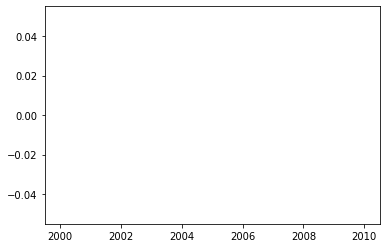

In [27]:
pdf = spark.sql("select * from test27").select("window", "Score", "time").toPandas()
from matplotlib import pyplot as plt
pdf.sort_values(by='time', inplace=True)
plt.plot(pdf["time"], pdf["Score"])

In [ ]:
spark.sql("select * from test27").select("time", "Score") \
 .write.mode("append") \
 .save("/content/drive/MyDrive/datatochart.csv",format="csv")

In [ ]:
import pandas as pd
pd.read_csv("/content/drive/MyDrive/datatochart")

FileNotFoundError: ignored

In [28]:
import time
df = spark.sql("select * from test27").toPandas()
DF = df
i = 1
while i<20:
  df = spark.sql("select * from test26").toPandas()
  DF = DF.append(df).drop_duplicates()
  time.sleep(5)
  i = i+1

AnalysisException: ignored

In [ ]:
DF

,window,sum(Followers),sum(ind),min(CreatedAt),Score,time
0,"(2021-05-31 22:36:00, 2021-05-31 22:42:00)",725441,104347.0,2021-05-31 22:39:37,0.143839,2021-05-31 22:36:00
1,"(2021-05-31 22:30:00, 2021-05-31 22:36:00)",4541327,-2482127.0,2021-05-31 22:30:00,-0.546564,2021-05-31 22:30:00
2,"(2021-05-31 22:24:00, 2021-05-31 22:30:00)",226767,44453.0,2021-05-31 22:28:30,0.196029,2021-05-31 22:24:00
3,"(2021-05-31 22:54:00, 2021-05-31 23:00:00)",1975208,115602.0,2021-05-31 22:54:53,0.058526,2021-05-31 22:54:00
4,"(2021-05-31 22:42:00, 2021-05-31 22:48:00)",781579,497215.0,2021-05-31 22:42:00,0.636167,2021-05-31 22:42:00
5,"(2021-05-31 23:06:00, 2021-05-31 23:12:00)",885342,586308.0,2021-05-31 23:09:30,0.662239,2021-05-31 23:06:00
6,"(2021-05-31 23:12:00, 2021-05-31 23:18:00)",991283,-104149.0,2021-05-31 23:12:00,-0.105065,2021-05-31 23:12:00
7,"(2021-05-31 23:24:00, 2021-05-31 23:30:00)",3815662,-1103344.0,2021-05-31 23:24:35,-0.289162,2021-05-31 23:24:00
8,"(2021-05-31 23:36:00, 2021-05-31 23:42:00)",1831191,-992561.0,2021-05-31 23:39:54,-0.542030,2021-05-31 23:36:00
9,"(2021-05-31 23:54:00, 2021-06-01 00:00:00)",1856193,350289.0,2021-05-31 23:54:46,0.188714,2021-05-31 23:54:00


In [1]:
pip install jupyter-dash -q

In [2]:
pip install dash-cytoscape -q

In [ ]:
pip install dash


# Nowa sekcja

In [ ]:
pip install plotly

In [3]:
from jupyter_dash import JupyterDash  # pip install dash
import dash_cytoscape as cyto  # pip install dash-cytoscape==0.2.0 or higher
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Output, Input
#import plotly.express as px
#import math
#from dash import no_update



In [4]:
from jupyter_dash import JupyterDash  # pip install dash
import dash_cytoscape as cyto  # pip install dash-cytoscape==0.2.0 or higher
import dash
from dash.dependencies import Output, Input
import dash_core_components as dcc
import dash_html_components as html
import plotly
import random
import plotly.graph_objs as go
from collections import deque
  

 

In [5]:
X = deque(maxlen = 20)
X.append(1)
  
Y = deque(maxlen = 20)
Y.append(1)
Y

deque([1])

In [8]:
 
app = JupyterDash(__name__)
  
app.layout = html.Div(
    [
        dcc.Graph(id = 'live-graph', animate = True),
        dcc.Interval(
            id = 'graph-update',
            interval = 1000,
            n_intervals = 0
        ),
    ]
)
  
@app.callback(
    Output('live-graph', 'figure'),
    [ Input('graph-update', 'n_intervals') ]
)
  
def update_graph_scatter(n_intervals):
    X.append(X[-1]+1)
    Y.append(Y[-1]+Y[-1] * random.uniform(-0.1,0.1))
  
    data = plotly.graph_objs.Scatter(
            x=list(X),
            y=list(Y),
            name='Scatter',
            mode= 'lines+markers'
    )
  
    return {'data': [data],
            'layout' : go.Layout(xaxis=dict(range=[min(X),max(X)]),yaxis = dict(range = [min(Y),max(Y)]),)}
  
if __name__ == '__main__':
    app.run_server(mode = 'inline')

<IPython.core.display.Javascript object>

deque([0.27095267012310786,
       0.2654034756697538,
       0.27352725099850855,
       0.29094844224069694,
       0.28034228273535916,
       0.28166963189818,
       0.2914207889205289,
       0.27793383215990475,
       0.2904148341072751,
       0.3057153452123089,
       0.3231963025631863,
       0.3220558333760733,
       0.337633174990494,
       0.35059871393871733,
       0.3210449207776418,
       0.3468032747692323,
       0.35901221888920887,
       0.39417393216747476,
       0.3844289164225448,
       0.4121770536950828])